# Homework 3

In [25]:
import folium
import pandas as pd
import numpy as np
import json
import os
from folium.features import TopoJson
import matplotlib.pyplot as plt
import seaborn as sns
from branca.colormap import StepColormap,LinearColormap,linear
from branca.utilities import color_brewer
from matplotlib import cm
from IPython.display import HTML

print('Folium version : ',folium.__version__)

Folium version :  0.5.0


Function allowing the display of the HTML of folium maps directly on Github :

In [26]:
def display(m, height=300):
    """Takes a folium instance and embed HTML."""
    m.render()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

**TODO : **
- I didn't know what to comment in the plots by nationality in question 3
- change names of the files


- **export folium to HTML and link them in your notebook**
- **Add interactivity**
- **DO the visualisation**
- **FIX SCALE FOR MAPS WHICH ARE COMPARED : HAVE THE SAME FOR BOTH**
- ADD STRING TO TOOLTIP


## Question 1: unemployment rate in Europe

### Definitions
In order for our analysis to be meaningful we need to be clear about what we are talking about. Taking the definitions given in the Eurostat website we will consider the following : 

**Unemployed persons** are all persons 15 to 74 years of age (16 to 74 years in ES, IT and the UK) who were not employed during the reference week, had actively sought work during the past four weeks and were ready to begin working immediately or within two weeks. Figures show the number of persons unemployed in thousands.

**Employed persons** are all persons who worked at least one hour for pay or profit during the reference week or were temporarily absent from such work. For the unemployment rate, only persons from 15 to 74 years of age are used.

The **unemployment rate** is the number of people unemployed as a percentage of the labour force. The labour force is the total number of people employed and unemployed. In the database, unemployment rates can be downloaded by chosing the unit "PC_ACT", Percentage of Active Population.

### Methodology
We want to create a dataframe with just the columns that we will need to visualize the data which are:
    - GEO code of each country
    - Name of the country
    - Value of the unemployment rate
    - Value of the unemployment rate relative to Switzerland

When loading the data, we want to select the rows where the value of the UNIT column is Percentage of active population, to be coherent with the previous definition of unemploymnet rate.

It was asked to consider recent data. To avoid seasonal trends we averaged the data over an entire year. For simplicity we stuck to the annual averages from 2016 which were recovered here : http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=une_rt_a&lang=en

Another thing worth commenting is that in the dataset that we used we didn't have the GEO code of the contries, so we had to mapp them by using a different dataset (http://ec.europa.eu/eurostat/web/products-datasets/-/ei_lmhr_m) were we had both country name and GEO code. For the mapping, we even had to manually correct some of the GEO codes that were incorrect (e.g. United Kingdom should be GB instead of UK). For that we took the oficial codes from http://www.nationsonline.org/oneworld/country_code_list.ht.

We will add the row for Switzerland at the end because we need it to visualise the plot of the unemployment rate relative to Switzerland. We used the value in https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_unemployment_rate. We would need more time to check if this value is coherent with our definition, and in addition, it's a value of the rate in 2015. As the value makes sense, we will assume it is coherent with our definition.

In [160]:
# Loading the data in the dataframe
file_path = r'une_rt_a_1_Data.csv'
EU_unemployment_df = pd.read_csv(file_path)

# Dropping unnecesary columns
EU_unemployment_df.drop(["AGE", "Flag and Footnotes", "SEX"], axis = 1, inplace = True)

# Selecting data
EU_unemployment_df = EU_unemployment_df.loc[EU_unemployment_df.TIME == 2016]
EU_unemployment_df = EU_unemployment_df.loc[EU_unemployment_df.UNIT=='Percentage of active population']

# Retaining relevant columns & deleting non-EU countries that were on the dataset
EU_unemployment_df = EU_unemployment_df[['GEO', 'Value']]
EU_unemployment_df.set_index("GEO", inplace = True)
EU_unemployment_df.drop(["United States", "Japan"], inplace = True)
EU_unemployment_df.reset_index(inplace = True)
EU_unemployment_df = EU_unemployment_df[~EU_unemployment_df.GEO.str.contains("Euro")]

# Cleaning GEO value of Germany which had an unwanted parentheses
EU_unemployment_df.GEO = EU_unemployment_df.GEO.str.replace(" \(until 1990 former territory of the FRG\)", "")

# Converting dtype of the unemployment rate column
EU_unemployment_df.Value = pd.to_numeric(EU_unemployment_df.Value)

As we said, to do the mapping we load the data from another dataset and we manually correct the GEO codes that are missing or incorrect.

In [161]:
# Recovering the geo codes of the country from another csv file
file_path = r'ei_lmhr_m_1_Data.csv'
# Loading the data in the dataframe, selecting columns & cleaning Germany as before
country_df = pd.read_csv(file_path)
country_df = country_df[['GEO', 'GEO_LABEL']]
country_df.GEO_LABEL = country_df.GEO_LABEL.str.replace(" \(until 1990 former territory of the FRG\)", "")
country_df.set_index("GEO_LABEL", inplace = True)

# Converting to a dict to do the mapping
GEO_Labels = country_df.to_dict()['GEO']

# Correcting erroneous country codes
GEO_Labels["United Kingdom"]= "GB"
GEO_Labels["Greece"]= "GR"

# Adding missing countries manually to the mapping with official country codes
GEO_Labels.update({"Swizerland":"CH"})
GEO_Labels.update({"Russia":"RU"})
GEO_Labels.update({"Albania":"AL"})
GEO_Labels.update({"Macedonia":"MK"})
GEO_Labels.update({"Montenegro":"ME"})
GEO_Labels.update({"Belarus":"BY"})
GEO_Labels.update({"Bosnia and Herzegovina":"BA"})
GEO_Labels.update({"Ukraine":"UA"})

# Mapping
EU_unemployment_df["GEO_LABEL"] = EU_unemployment_df["GEO"].map(lambda x: GEO_Labels[x])
EU_unemployment_df.set_index('GEO', inplace=True)

# Adding Switzerland row
EU_unemployment_df.loc["Swizerland"] = [3.4, "CH"]

# Computing the differences in unemployment compared to Switzerland
EU_unemployment_df["Relative To Switzerland"] = EU_unemployment_df["Value"]- EU_unemployment_df.loc["Swizerland"].Value
EU_unemployment_df.head()

Value GEO_LABEL  Relative To Switzerland
GEO                                                     
Belgium           7.8        BE                      4.4
Bulgaria          7.6        BG                      4.2
Czech Republic    4.0        CZ                      0.6
Denmark           6.2        DK                      2.8
Germany           4.1        DE                      0.7

### Visualization 

Before doing the plots we need to take into account:
- the number of variables 
- color and scale
- data classification method
- possible interactivity

We used a sequential color palette as we are only representing one variable. The thresholds / bins were selected based on the quartiles. The scale was selected in order to have 5 levels, each one containing 20% of the countries.

To load the provided topojson files we used http://jeffpaine.github.io/geojson-topojson/ to convert them to geojson.

With the choropleth function of folium we couldn't change the color and other parameters the way we wanted so we took the original code of the function and defined our own function *my_choroplet* which allows us to change these parameters.

In [162]:
def my_choropleth(map,fill_color,geo_json_data,data,data_columns,bins,colormap):
    
    ### FIXED PARAMETERS FOR EVERY CHOROPLETH
    
    line_weight= 1
    line_opacity = 0.2
    line_color = 'black'
    no_data_color = 'grey'
    fill_opacity = 0.7
    
    # creates the color_range !!! TO CORRECT 
    key_on='id'
    color_data = data.set_index(data_columns[0])[data_columns[1]].to_dict()
    color_domain = list(bins)
    color_range = colormap.to_step(index=bins)
    
  

    # function mapping the keys to colors : 
    def get_by_key(obj, key):
        return (obj.get(key, None) if len(key.split('.')) <= 1 else
        get_by_key(obj.get(key.split('.')[0], None) , '.'.join(key.split('.')[1:])))

    def color_scale_fun(x):
        if get_by_key(x, key_on) in color_data:
            t = [u for u in color_domain if u <= color_data[get_by_key(x, key_on)]]
            ind = len(t)
            return color_range(color_data[get_by_key(x, key_on)])
        
        else:
            return no_data_color
        
    def fill_opacity_fun(x):
        return fill_opacity if get_by_key(x, key_on) in color_data else 0

    # creating the styles for the map :

    def style_function(x):
            return {
                'weight': line_weight,
                'opacity': line_opacity,
                'color': line_color,
                'fillOpacity': fill_opacity_fun(x),
                'fillColor': color_scale_fun(x)
            }
    
    def highlight_function(x):
            return {
                'weight': line_weight + (2 if get_by_key(x, key_on) in color_data else 0) ,
                'fillOpacity': (fill_opacity + .2 if get_by_key(x, key_on) in color_data else 0.2),
            }

    
    ### mapping the countries and their fill color :

    folium.GeoJson(geo_json_data,
            name='Name GEO',
            style_function=style_function,
            smooth_factor=None,
            highlight_function=highlight_function
              ).add_to(map)


    ### adding the color scale :
    # Continuous colors :
    colormap.add_to(map)

    # Step colors 
    step_colormap = color_range
    step_colormap.caption = colormap.caption
    step_colormap.add_to(map)

### EU unemployment by country

In [163]:
# Create the map object
EU_coordinates = [53.5775, 23.106111]
EU_map = folium.Map(location=EU_coordinates, tiles='cartodbpositron', zoom_start=3)

# Loading the borders of european countries from geojson file
countries_geo = os.path.join('topojson', 'europe.geojson.json')
geo_json_data = json.load(open(countries_geo))

# Defining the bins
bins = EU_unemployment_df.quantile([0.2*i for i in range(6)])
bins = bins['Value'].tolist()

# Loading data & defining extra variables
data=EU_unemployment_df
columns=['GEO_LABEL', 'Value']
legend = 'Percentage of unemployment rate within the active population'
colors_colormap = ['forestgreen', 'cornsilk','red']
index_colormap = [min(bins), 5, max(bins)]

mycolormap = LinearColormap(colors_colormap,
                            index=index_colormap,
                            vmin=min(index_colormap),vmax=max(index_colormap),
                            caption=legend)

my_choropleth(EU_map, fill_color, geo_json_data, EU_unemployment_df, columns, bins, mycolormap)

EU_map.save('HTMLmaps/EU_map_Global.html')
EU_map

### Comparison with Switzerland

In this case we used a divergent pallette because we have an origin with a meaning, in this case, the origin is the value of Switzerland which is obviously zero so we set it to white color.

In [145]:
from folium import StepColormap
from branca.utilities import color_brewer 

# Create map object & setting divergent pallette
EU_coordinates = [53.5775, 23.106111]
EU_map = folium.Map(location=EU_coordinates, tiles='cartodbpositron', zoom_start=3)
bins = [-3,-2,-1,0,1,2,5,10]
legend = 'Difference with switzerland'
colors_colormap = ['blue','white','crimson']
index_colormap = [min(bins),0,max(bins)]

mycolormap = LinearColormap(colors_colormap,
                          index=index_colormap,
                          vmin=min(index_colormap), vmax=max(index_colormap),
                          caption=legend)


columns=['GEO_LABEL', 'Relative To Switzerland']
my_choropleth(EU_map , fill_color , geo_json_data , EU_unemployment_df.drop('Swizerland') , columns, bins,mycolormap)

EU_map.save('HTMLmaps/EU_map_Global.html')
EU_map

### Comment

As we can see, Switzerland is one of the countries with the lowest unemployment rate, at the level of countries like Germany and Norway.

Iceland is the only country that has a lower unemployment rate.

## Question 2: Unemployment Rates In Switzerland

We need to analyze the different unemployment rates by considering the different cantons, age groups and foreigners vs. swiss.

Therefore we want to extract : 
- unemployment rate of different cantons in CH 15-74 years (question 2)
- unemployment rate of different cantons in CH 15-74 years making a distinction between *Swiss* and *foreign* (question 3) 
- unemployment rate of different cantons in CH taking differences between age groups (question 3)

### Methodology

The columns that we need are: 
- Canton name
- durchschnittliche Anzahl Arbeitslose (which corresponds to the number of unemployed people in each canton)
- Taux de chômage (1 cav): two columns had the same name. The first one has the values for the total unemployment rate and the second one has the values of the unemployment rates for people over 50 years.

To do the second part of question 2, we computed the total number of active people in each canton. By using the total number of unemployed people and the unemployment rate of each canton you can compute the total number of active people using the following formula:

$$Active\;Population = \frac{Number\;Of\;Unemployed\;People}{Total\;Unemployment\;Rate} · 100$$


In the files recovered containing the unemployment rates, the names of the cantons were all in French. Therefore we mapped the GEOIDs of the cantons to the french names in order to do the choropleth map. This is in the DictCantonGeo.csv

### Total Unemployment Rate

First we defined a function that fixed an issue when loading the data.

In [167]:
def split_comma_df(df):
    """ This function fixes loading issues with the dataframe. All values for the columns where loaded into one single column
    and this function splits the values and column names and returns the dataframe with the right format"""
    
    col_names = df.columns[0]
    col_names = col_names.replace("\"", "").replace("\'", "").split(",")
    df.columns = [0]
    df[0] = df[0].str.replace("\"", "").replace("\'", "")
    df = df[0].str.split(',', expand=True)
    # Recovering column names
    df.columns = col_names
    return df

In [168]:
# Loading the unemployment rates of each canton & reformatting the loading issues
file_path = r'chomage_total.csv'
df_CH = pd.read_csv(file_path, encoding='utf-16', sep = ",")
df_CH = split_comma_df(df_CH)

# Selecting columns that we are interested in & renaming them
df_CH = df_CH[["Canton", "durchschnittliche Anzahl Arbeitslose", "Taux de chômage (1 cav)"]]
df_CH.columns = ["Canton", "Number Of Unemployed People",'Total', 'More than 50 years']

Then we computed the Total Active Population per canton using the formula and added the values as a column in the *df_CH* dataframe

In [169]:
df_CH['Number Of Unemployed People'] = df_CH['Number Of Unemployed People'].apply(str.replace, args=("'", ""))
df_CH['Number Of Unemployed People'] = pd.to_numeric(df_CH['Number Of Unemployed People'])
df_CH.Total = pd.to_numeric(df_CH.Total)
df_CH['Active Population'] = 100*df_CH['Number Of Unemployed People']/df_CH["Total"]
df_CH['Active Population'] = df_CH['Active Population'].apply(lambda x: int(np.ceil(x)))

We did the mapping of the names of the cantons and merged with the previous dataframe

In [170]:
# Loading the data of the Swiss canton names and their respective geo codes
df_geolabel = pd.read_csv('DictCantonGeo.csv',sep=';', encoding='utf-8')

df_CH = pd.merge(df_CH,df_geolabel,on='Canton', how='outer')
df_CH.set_index("Canton", inplace = True)
df_CH.head()

Number Of Unemployed People  Total More than 50 years  \
Canton                                                           
Zurich                         30084    3.7                3.1   
Berne                          15283    2.7                2.4   
Lucerne                         4602    2.1                1.8   
Uri                              202    1.0                1.0   
Schwyz                          1537    1.8                2.0   

         Active Population GEO  
Canton                          
Zurich              813082  ZH  
Berne               566038  BE  
Lucerne             219143  LU  
Uri                  20200  UR  
Schwyz               85389  SZ

In [171]:
# Creating the map object
CH_coordinates = [46.818188, 8.227512]
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=8)

# Loading the borders of Switzerland
CH_geo = os.path.join('topojson', 'ch-cantons.topojson.json')
geo_json_data = json.load(open(CH_geo))

# Setting bins splitting with quantiles
bins = df_CH[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_CH,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             threshold_scale = bins,
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Unemployment by canton')

CH_map

### Comment

In this visualization we can see an interesting fact. If we focus on the language, the unemployment is different between the three parts of Switzerland. The french and italian part have unemployment rates over 3% while the german speaking part generally has less than 3%.

Another thing worth mentioning is that the cantons that have a higher unemployment rate are all near the border with the neighbour countries.

### Unemployment counting only people who do not have jobs

### Methodology

When considering unemployment it is important to account for seasonal trends. That is why it is not sufficient to take information for just one month. To have relevant and sufficient data we wanted to analyze over an entire year. As this data is not yet available for 2017, we decided to use the information from 2016. For the annual value, we computed the average of all the months.

The goal is to do two plots:

    1) Unemployment rate with the new definition
    2) Plot of the following ratio: unemployed people counting people that have a job and is looking for a new one vs. unemployed people counting only people who do not have jobs


To visualize 1) we start by loading the data that we will use to get the number of unemployed people that have a job and is looking for a new one.

In [173]:
# Loading the data
file_path = r'non_chomeurs_demandent_emploi.csv'
df_looking_job = pd.read_csv(file_path, encoding = 'utf-16')
df_looking_job.drop('Mois', axis=1, inplace=True)

# Reformatting the values that have a "'" to convert them to integers
for column in df_looking_job.columns:
    df_looking_job[column] = df_looking_job[column].apply(str)
    df_looking_job[column] = df_looking_job[column].apply(str.replace, args=("'", ""))

# Converting values to numeric 
df_looking_job = df_looking_job.apply(pd.to_numeric, errors='ignore')

# Computing the annual value of the unemployment rate from the monthly data
df_looking_job['2016'] = df_looking_job.mean(axis=1)
df_looking_job['2016'] = df_looking_job['2016'].apply(lambda x: int(np.ceil(x)))

# Selecting just the unemployed people that have a job and is looking for a new one
df_looking_job = df_looking_job.loc[df_looking_job.Mesures=="Demandeurs demploi non chômeurs"]
df_looking_job = df_looking_job[['Canton', '2016']]
df_looking_job.set_index('Canton', inplace=True)

# Drops the last row which was a totals value that we don't need
df_looking_job.drop(df_looking_job.index[-1], inplace=True)

The unemployment rate (*new_UR_definition*) using the new definition is computed by taking the number of unemployed people, subtracting the number of unemployed people that have a job and is looking for a new one, and dividing by the active population in each canton, which we computed previously in the first part of question 2.

In [174]:
subtraction = df_CH['Number Of Unemployed People'].subtract(df_looking_job['2016'])
df_CH['new_UR_definition'] =  subtraction.divide(df_CH['Active Population'])*100

In [175]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=8)

bins = df_CH[["new_UR_definition"]].quantile([0.2*i for i in range(6)])
bins = bins["new_UR_definition"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_CH,
             columns=['GEO', 'new_UR_definition'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins,
             legend_name='Unemployment Of Swiss by Canton with new definition')
CH_map

### Comment 

We can see that with the new definition the unemployment rate increases in the most important places economically speaking. Generally where the big cities are: Bern, Geneva, Zurich. So we conclude that for some reasons in big cities people is not happy with their job and is looking for a new one. 

Although this is a rough hypothesis, we can show the importance of knowing and understanding the data that you are plotting. We would not have considered this hypothesis without plotting this second map.

To visualize 2) we first compute the ratio that we want to plot. We would like to see how much people out of the considered unemployed has a job but is looking for a new one.

In [176]:
df_CH['percentage of unemployed people working over unemployed'] = df_looking_job['2016'].divide(df_CH['Number Of Unemployed People'])*100
df_CH.head()

Number Of Unemployed People  Total More than 50 years  \
Canton                                                           
Zurich                         30084    3.7                3.1   
Berne                          15283    2.7                2.4   
Lucerne                         4602    2.1                1.8   
Uri                              202    1.0                1.0   
Schwyz                          1537    1.8                2.0   

         Active Population GEO  new_UR_definition  \
Canton                                              
Zurich              813082  ZH           2.875725   
Berne               566038  BE           1.851642   
Lucerne             219143  LU           0.792633   
Uri                  20200  UR           0.198020   
Schwyz               85389  SZ           0.918151   

         percentage of unemployed people working over unemployed  
Canton                                                            
Zurich                                           22.277623        
Berne                                            31.420533        
Lucerne                                          62.255541        
Uri                                              80.198020        
Schwyz                                           48.991542

In [191]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

bins = df_CH[["percentage of unemployed people working over unemployed"]].quantile([0.2*i for i in range(6)])
bins = bins["percentage of unemployed people working over unemployed"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_CH,
             columns=['GEO', 'percentage of unemployed people working over unemployed'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins,
             legend_name='percentage of unemployed people working over unemployed')

CH_map

### Comment 

We can see that the overall values of this particular ratio are very high. There is a lot of people that have a job but is looking for a new one. In fact, we can see that more than half of the cantons have the ratio over 50%. 

The data shown in this visualization is coherent with the previous plot. The high ratios here correspond to low levels in the previous one, and it's the same the other way around.

## Question 3 : Unemployment Rates in Switzerland - Other Factors

### Unemployment rate by nationality

We used the dataset from the folder "Chomeurs et demandeurs d'emploi/Moyenne des chomeurs et tax de chomage par an" and then we selected to export the data by nationality. 

We had the same issue as in question 2 so we used *split_comma_df* function to format the dataframe.

We decided to visualize the data using three different plots. First, the rate considering just Suiss people. Second, considering just foreigners. 

Finally, we computed the difference of unemployment rates and we plotted it in a map. We decided to go with this kind of plot because then we can use a divergent pallette that would fit the data very nicely. The zero would mean equality, and then we would use two colors to show if the inequality favours either Swiss or foreigners. 

We think this is the easiest and most intuitive way to show if there is a global nationality inequality in Switzerland. 

In [192]:
# Loading rates in Switzerland
file_path = r'chomage_nationality.csv'
df_CH_nationality = pd.read_csv(file_path, encoding='utf-16', sep = ",")
df_CH_nationality = split_comma_df(df_CH_nationality)

# Merging the geolabel to the dataframe & selecting useful columns
df_CH_nationality = pd.merge(df_CH_nationality,df_geolabel,on='Canton', how='outer')
df_CH_nationality = df_CH_nationality[["Canton","GEO", "Taux de chômage (1 cav)", "Nationalité"]]
df_CH_nationality.set_index(["Nationalité"], inplace = True)
df_CH_nationality.columns = ["Canton", "GEO", 'Total', 'Au dessus de 50 ans']

# Convert values to numeric
df_CH_nationality.Total = pd.to_numeric(df_CH_nationality.Total)
df_CH_nationality.head()

Canton GEO  Total Au dessus de 50 ans
Nationalité                                        
Etrangers     Zurich  ZH    6.0                 6.3
Suisses       Zurich  ZH    2.8                 2.5
Etrangers      Berne  BE    6.5                 6.9
Suisses        Berne  BE    2.0                 1.9
Etrangers    Lucerne  LU    4.7                 5.2

We define the function that will grab the data of either all Swiss people or all foreigners and then we compute the difference as we stated previously.

In [193]:
def extract_df_nationality(df, nationality):
    df = df.loc[nationality]
    df.reset_index(inplace = True)
    df = df.drop("Nationalité", axis = 1)
    df.set_index("Canton", inplace = True)
    return df

# Grab data
df_foreigners = extract_df_nationality(df_CH_nationality, "Etrangers")
df_swiss = extract_df_nationality(df_CH_nationality, "Suisses")

# Dataframe containing the difference between swiss and foreign unemployment
df_difference = df_swiss.copy()
df_difference = df_difference.drop("Au dessus de 50 ans", axis = 1)
df_difference.Total = df_foreigners.Total-df_difference.Total

**SWISS**

In [195]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=8)

bins = df_swiss[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_swiss,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins,
             legend_name='Unemployment Of Swiss by canton')

CH_map

** FOREIGNERS **

In [196]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=8)

bins = df_foreigners[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_foreigners,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins, 
             legend_name='Unemployment Of Foreigners by canton')

CH_map

** DIFFERENCE BETWEEN THE TWO **

In [182]:
CH_map = folium.Map(location=CH_coordinates, tiles='cartodbpositron', zoom_start=7)

bins = df_difference[["Total"]].quantile([0.2*i for i in range(6)])
bins = bins["Total"].tolist()

CH_map.choropleth(geo_data=geo_json_data, topojson= "objects.cantons", data=df_difference,
             columns=['GEO', 'Total'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = bins, 
             legend_name='Unemployment Of Foreigners by canton')

CH_map

**Where are the differences most visible ? Why do you think that is ?**

### Comment

BLA

BLA

BLA

### Unemployment Rate by Age

We used the dataset from the folder "Chomeurs et demandeurs d'emploi/Moyenne des chomeurs et tax de chomage par an" and then we selected to export the data by groups of age. We had the option of exporting the data with bins of ages of 5 years, but this would make the barplots unnecessarely ugly. We decided to choose the option of three groups of ages: from 14-24 years, 25-49 years, and over 49.

In [197]:
# Loading rates in Switzerland
file_path = r'chomage_age.csv'
df_CH_age = pd.read_csv(file_path, encoding='utf-16', sep = ",") 

# Merging the geolabel to the dataframe & selecting useful columns
df_CH_age = pd.merge(df_CH_age,df_geolabel,on='Canton', how='outer')
df_CH_age = df_CH_age[["Canton","GEO","Taux de chômage (1 cav)", "Unnamed: 3"]]
df_CH_age.columns = ["Canton", "GEO", 'Total', "Age Group"]
df_CH_age.set_index(["Canton", "Age Group"], inplace = True)

# Convert values to numeric
df_CH_age.Total = pd.to_numeric(df_CH_age.Total)

df_CH_age.head()

GEO  Total
Canton Age Group                
Zurich 15-24 ans       ZH    4.1
       25-49 ans       ZH    3.8
       50 ans et plus  ZH    3.1
Berne  15-24 ans       BE    2.9
       25-49 ans       BE    2.9

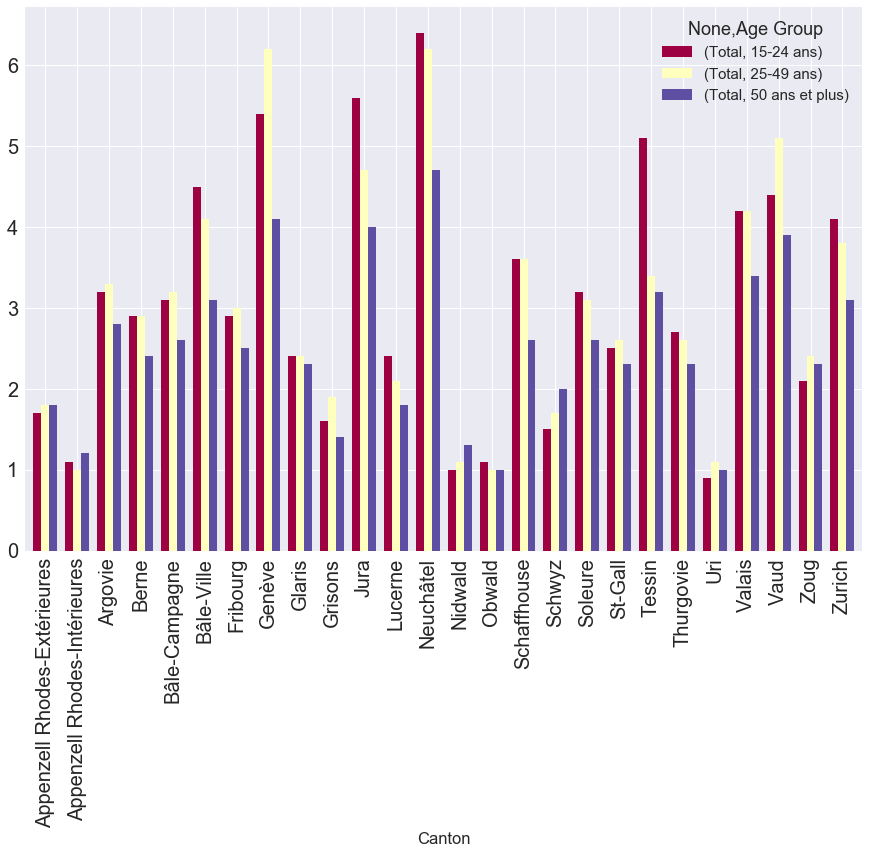

In [198]:
sns.set_style("white");
sns.set_palette(sns.color_palette("hls", 8));
sns.set(font_scale = 1.5);
cmap = cm.get_cmap('Spectral');
plt.figure();
ax = df_CH_age.unstack().plot(kind='bar', figsize=(15, 10), legend=True, fontsize=20, width = 0.75, colormap= cmap);
plt.show()

### Comment

In this bar plot we can see why we chose the option of three age groups instead of the bins of 5 years. If the plot is already more dense than what we would like, with the other option it would be imposible to understand anything.

we chose very contrasted colors because there are a lot of bars and we wanted them to be very different in a glance. 

Genève, Neuchatel and Jura are the cantons with the most unemployment rate, while Nidwald, Obwald and Uri have the lowest ones.
We see that there is a pattern (with few exceptions). People over 49 have lower unemployment rates.

Another interesting conclusion that we can extract from the data is that the difference whithin the age groups is higher in the cantons that have the highest unemployment rates, while it remains more constant for the lower ones.

## 4. Bonus : Röstigraben

We first started by placing each canton in the correct region (German, French or Italian). For cantons which are in between several regions, we assigned them based on the language which is majoritaily spoken.

In [79]:
romande = ["Jura", "Fribourg", "Valais", "Genève", "Neuchâtel"]
tessinois = ["Tessin"] 
df_CH["Rostigraben"] = "GE"
df_CH.loc[romande,'Rostigraben'] = "FR"
df_CH.loc[tessinois,'Rostigraben'] = "IT"

NameError: name 'df_CH' is not defined

We now change the Rostrigraben column to categorical values to be able to compute correlations and see whether the region has significant influence on the unemployment rate.

In [80]:
df_CH['Rostigraben'] = df_CH['Rostigraben'].astype('category')
df_CH['Rostigraben (Codes)'] = df_CH['Rostigraben'].cat.codes.tolist()
df_CH[['Rostigraben (Codes)', 'Total']].corr("spearman")

NameError: name 'df_CH' is not defined

The correlation between the region defined by the Rostigraben and the total unemployment rates in the canton exists. There could be an influence there but the a correlation of -0.44 is too low to be significant. Nonetheless we can look at the characteristics of these unemployment rates per region.

In [ ]:
df_CH[['Rostigraben', 'Total']].groupby("Rostigraben").describe()

First thing which is important to note is that there are not the same number of cantons per region which has an impact on the quality of the statistics. Nonetheless there are certain things which can be noted :

- the largest unemployment rate in the german side (3.05%) is quite close to the smallest on the french side (2.8%) and definitely lower than the unemployment rate in the Italian side (3.5%).
- as there is only the Ticino in the Italian side we will only focus on comparing between the French and German cantons. On all fronts, be it the aveage, minimum, or the quartiles, the german side seems to be faring much better with around 1/3 less unemployment.